In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pyvo as vo
from IPython.display import Image as ipImage, display
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
import sys
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
import importlib
import proj2_runfile
importlib.reload(proj2_runfile)
from proj2_runfile import HUDF_Plotter, HUDF_z_Catalog


In [50]:
hudf_plotter = HUDF_Plotter()

INFO: Loading Hubble UDF fits files...
INFO:   Loading i image
INFO:   Loading v image
INFO:   Loading b image
INFO: Finished loading.
INFO: Converting to RGB image...


In [51]:
hudf_plotter.add_z_catalog(catalog_id='J/AJ/150/31/table5', zcol='zph1', 
                           mag_constraint=25, catalog_key='photz_raf', color='y')
hudf_plotter.add_z_catalog(catalog_id='J/A+A/608/A2/combined', zcol='zMuse', 
                           mag_constraint=25, catalog_key='specz_muse', color='m')

In [53]:
hudf_plotter.cross_match_catalogs('photz_raf', 'specz_muse', 'cross-match', 'c')

(<Figure size 1200x1200 with 1 Axes>,
 <WCSAxesSubplot:xlabel='RA (deg)', ylabel='DEC (deg)'>)

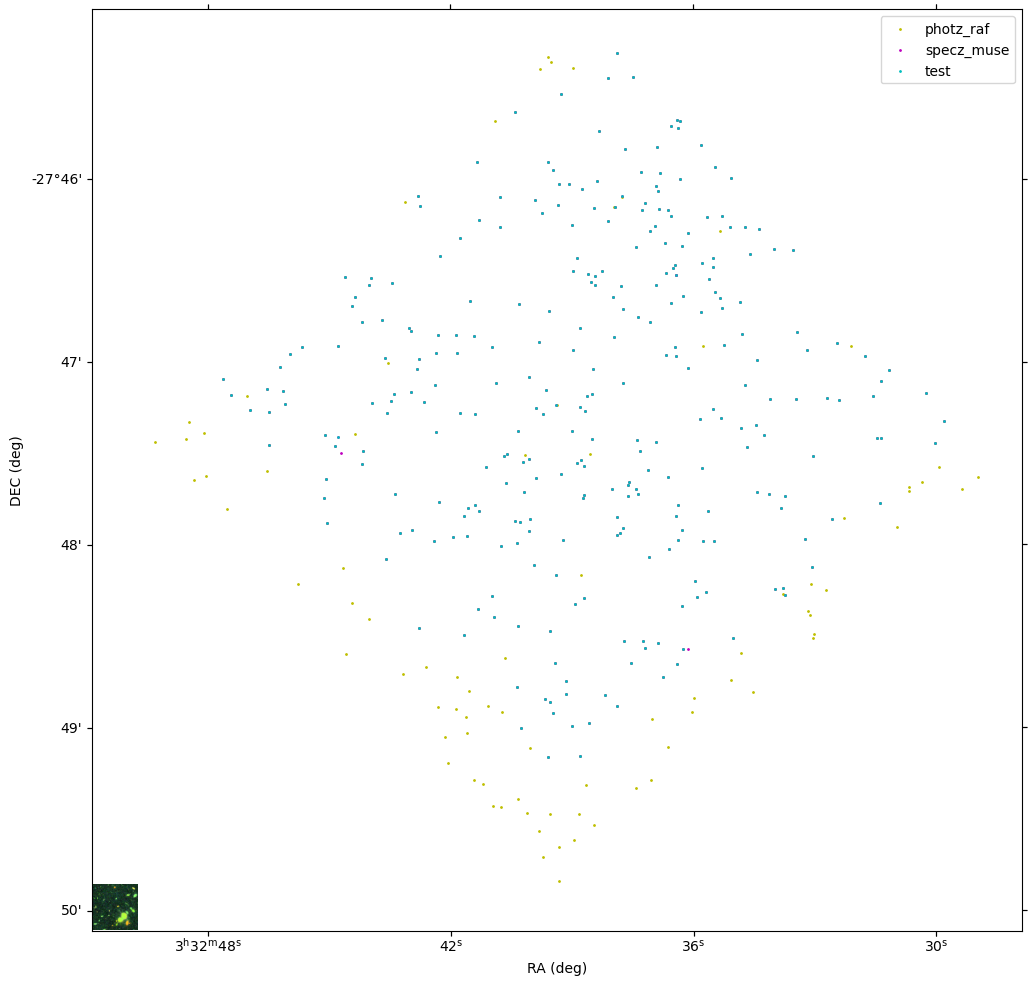

In [54]:
hudf_plotter.plot()

In [47]:
print(hudf_plotter.z_catalogs['photz_raf'].coords.size)
print(hudf_plotter.z_catalogs['specz_muse'].coords.size)
print(hudf_plotter.z_catalogs['test'].coords.size)

380
302
299


In [54]:
test = HUDF_z_Catalog('J/AJ/150/31/table5', zcol='zph1', mag_constraint=25)
type(test.coords)

astropy.coordinates.sky_coordinate.SkyCoord

In [2]:
hudf = []
hudf_header = []
xmin = 4000
xmax = 6500
ymin = 4000
ymax = 6500
rgb_scale = (0.6, 0.3, 0.9)
rgb_max = 0.001
print('Loading Hubble UDF fits files...')
for i, c in enumerate(['i', 'v', 'b']):
    txt = f'\r    Loading {c} image'
    sys.stdout.write(txt)
    sys.stdout.flush()
    with fits.open(f'data/h_udf_wfc_{c}_drz_img.fits') as hdul:
        #hudf.append(hdul[0].data[xmin:xmax,ymin:ymax])
        #hudf.append(hdul[0].data * rgb_scale[i])
        #hudf[i][hudf[i] > rgb_max] = rgb_max
        hudf_header.append(hdul[0].header)
print('')
print('Finished Loading')

Loading Hubble UDF fits files...
    Loading b image
Finished Loading


In [12]:
r = hudf[0]
g = hudf[1]
b = hudf[2]

In [40]:
hudf[0].shape

IndexError: list index out of range

In [3]:
wcs = WCS(hudf_header[0])
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.122751  -27.805089  
CRPIX : 9470.5  3610.5  
CD1_1 CD1_2  : -8.3333333333333e-06  0.0  
CD2_1 CD2_2  : 0.0  8.33333333333334e-06  
NAXIS : 10500  10500

In [11]:
type(wcs)

astropy.wcs.wcs.WCS

In [9]:
r = hudf[0] * 0.6
g = hudf[1] * 0.3
b = hudf[2] * 0.9
t =  0.001
r[r > t] = t
g[g > t] = t
b[b > t] = t

# hudf_rgb = make_lupton_rgb(r, g, b, Q=0.00001, stretch=0.0012, filename='hudf.jpeg')

# fig = plt.figure(figsize=(12,12))
# axes = fig.add_subplot(111, projection=wcs)
# axes.imshow(hudf_rgb, origin='lower')
#axes.scatter(pixel_coords[0], pixel_coords[1], s=1)

In [7]:
hudf_rgb = make_lupton_rgb(r, g, b, Q=0.0001, stretch=0.001, filename='hudf.jpeg')

In [4]:
from proj2_runfile import load_hudf_z_vizier
### Load redshifts from catalogs
catalog_ids = {
    'photz_raf':'J/AJ/150/31/table5', 
    'specz_muse':'J/A+A/608/A2/combined'
}
photz_raf = load_hudf_z_vizier(catalog_ids['photz_raf'], zcol='zph1', mag_limit=25)
specz_muse = load_hudf_z_vizier(catalog_ids['specz_muse'], zcol='zMuse', mag_limit=25)

### Crossmatch catalogs
idx, sep2d, dist3d = specz_muse['sky'].match_to_catalog_sky(photz_raf['sky'])
crossmatchz = {}
for key, vals in photz_raf.items():
    crossmatchz[key] = vals[idx]
print(photz_raf['sky'].size)
print(specz_muse['sky'].size)
print(crossmatchz['sky'].size)

pixels_photz = wcs.world_to_pixel(photz_raf['sky'])
pixels_specz = wcs.world_to_pixel(specz_muse['sky'])
pixels_bothz = wcs.world_to_pixel(crossmatchz['sky'])

380
302
302


In [61]:
coord = SkyCoord('03h32m42s -27d47m00s', unit=(u.hourangle, u.deg))
size = 20 * u.arcsec
box_pixels = wcs.world_to_pixel(coord)
dra = coord.ra + size
ddec = coord.dec + size
dpixel = wcs.world_to_pixel(SkyCoord(dra, ddec))
dpixel = (np.abs(dpixel[0] - box_pixels[0]), np.abs(dpixel[1] - box_pixels[1]))
print(dpixel)
box_pixels = (box_pixels[0] - dpixel[0]/2, box_pixels[1] - dpixel[1]/2)
print(box_pixels)
dpixel = np.mean(dpixel)
print(dpixel)
# ras = [coord.ra - size/2, coord.ra - size/2, coord.ra + size/2]
# decs = [coord.dec - size/2, coord.dec + size/2, coord.dec - size/2]
# box_coord = SkyCoord(ras, decs)
# box_pixels = wcs.world_to_pixel(box_coord)
# print(box_pixels)
# test1 = (box_pixels[0][0] - box_pixels[0][2])
# test2 = (box_pixels[1][0] - box_pixels[1][1])

(590.1253067926527, 666.4028611552549)
(3626.99228915719, 5885.450416038458)
628.2640839739538


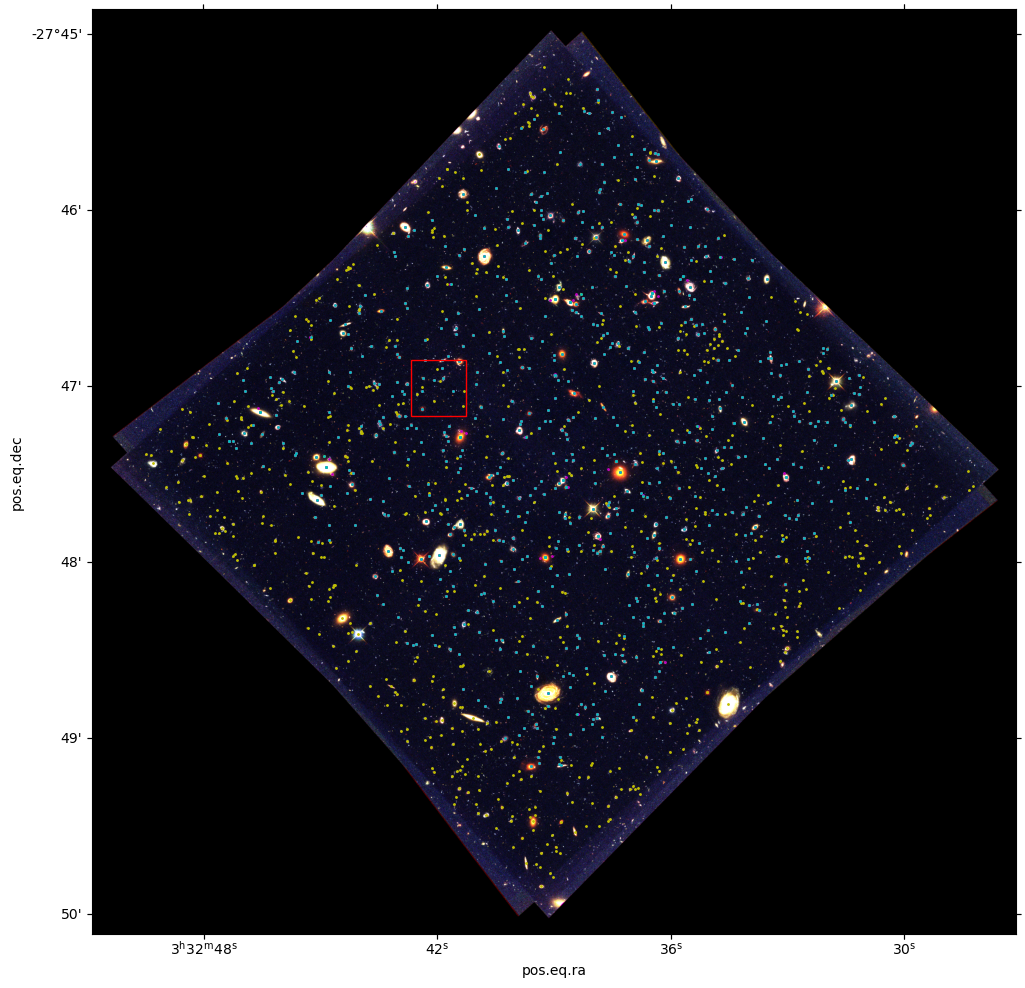

: 

In [62]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(hudf_rgb, origin='lower')
ax.scatter(pixels_photz[0], pixels_photz[1], s=1, c='y', label='Photo-')
ax.scatter(pixels_specz[0], pixels_specz[1], s=1, c='m')
ax.scatter(pixels_bothz[0], pixels_bothz[1], s=1, c='c')

coord = SkyCoord('03h32m42s -27d47m00s', unit=(u.hourangle, u.deg))
size = 20 * u.arcsec

rect = plt.Rectangle(box_pixels, dpixel, dpixel, fill=False, color='r')

ax.add_patch(rect)

In [8]:
services = vo.regsearch(keywords='hubble udf')
services.to_table()['ivoid','short_name','res_title']

ivoid,short_name,res_title
object,object,object
ivo://cds.vizier/ii/258,II/258,Hubble Ultra Deep Field Catalog (UDF)
ivo://cds.vizier/j/aj/132/926,J/AJ/132/926,Galaxies in the Hubble Ultra Deep Field
ivo://cds.vizier/j/aj/150/31,J/AJ/150/31,Photometry and redshifts of galaxies in the UDF
ivo://cds.vizier/j/apj/612/l93,J/ApJ/612/L93,Candidates of z~5.5-7 galaxies in the HST-UDF
ivo://cds.vizier/j/apj/624/l5,J/ApJ/624/L5,IR photometry of z~10 galaxies in NICMOS fields
ivo://cds.vizier/j/apj/631/85,J/ApJ/631/85,Galaxy morphologies in the Hubble UDF
ivo://cds.vizier/j/apj/639/724,J/ApJ/639/724,Tadpole galaxies in the Hubble UDF
ivo://mast.stsci/siap/hst.udf,HST.UDF,HST Ultra Deep Field (UDF) Images
ivo://mast.stsci/siap/udfuv,HST.udfuv,Hubble Space Telescope Ultraviolet Images of the UDF and HDF


In [9]:
coord = SkyCoord('3 32 38.92 -27 47 29.37', unit=(u.hourangle, u.degree))
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (53.16216667, -27.79149167)>

In [12]:
im_table = services[2].search(pos=coord)
im_table.to_table()

_r,recno,UDF,RAJ2000,DEJ2000,zsp,r_zsp,zph1,e_zph1,E_zph1,chi2m,Pzph1,zph2,e_zph2,E_zph2,chi2r,Pzph2,SimbadName
,,,deg,deg,,,,,,,,,,,,,
float64,int32,str5,float64,float64,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str15
0.030771,1,373,53.15437485,-27.82148101,1.14,5,1.22,0.10,0.10,0.51,0.99,1.11,0.10,0.12,1.22,1.00,[CBS2006] 224
0.027765,2,534,53.16170093,-27.81925383,0.67,6,0.65,0.08,0.06,0.10,1.00,0.61,0.11,0.09,0.56,1.00,[CBS2006] 355
0.025879,3,865,53.17450843,-27.81495550,0.67,1,0.64,0.08,0.07,0.06,0.99,0.61,0.10,0.09,0.84,1.00,[CBS2006] 662
0.024990,4,983,53.14989262,-27.81400031,1.31,6,1.28,0.10,0.10,0.22,0.99,1.24,0.11,0.11,1.44,1.00,[CBS2006] 797
0.026427,5,1035,53.17634676,-27.81475285,2.44,6,2.42,0.15,0.15,0.68,1.00,1.99,1.94,0.13,7.85,0.93,[CBS2006] 830
0.022407,6,1060,53.15915906,-27.81374038,1.77,8,1.74,0.13,0.11,0.27,0.99,1.71,0.08,0.08,2.45,1.00,[CBS2006] 853
0.022732,7,1077,53.16529350,-27.81405511,3.06,2,3.32,0.19,0.18,0.73,1.00,3.04,0.17,0.29,1.03,1.00,[CBS2006] 865
0.022088,8,1134,53.16817307,-27.81293086,0.96,6,1.00,0.09,0.09,0.18,0.99,0.79,0.10,0.09,1.48,1.00,[CBS2006] 901


In [17]:
coord = SkyCoord('3h32m38.92s -27d47m29.37s', unit=(u.hourangle, u.degree))
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (53.16216667, -27.79149167)>

In [ ]:
J/A+A/608/A2 MUSE
J/AJ/150/31 Rafelski 2015

In [16]:
catalog_list = Vizier.find_catalogs('Photometry and redshifts of galaxies in the UDF')
print({k:v.description for k,v in catalog_list.items()})

{'J/AJ/150/31': 'Photometry and redshifts of galaxies in the UDF (Rafelski+, 2015)'}


In [17]:
catalog = Vizier.get_catalogs(list(catalog_list.keys())[0])
catalog

TableList with 2 tables:
	'0:J/AJ/150/31/table5' with 20 column(s) and 50 row(s) 
	'1:J/AJ/150/31/table4' with 9 column(s) and 50 row(s) 

In [41]:
result = Vizier.query_region(coord, radius=Angle(4.0, 'arcmin'), catalog=catalog_name)
result

Empty TableList

In [9]:
from astroquery.sdss import SDSS

In [24]:
result = SDSS.query_region(coord, radius='2 arcsec')

In [25]:
print(result)

None
